In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from ccl import ccl
from morphology_misc import erosion, dilation, closing, opening

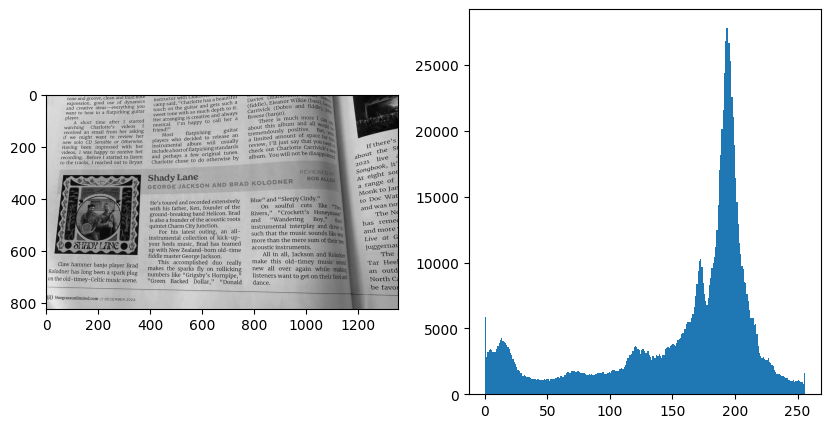

In [55]:
image = plt.imread('shady_text.jpg')[:,:,0]
# image = plt.imread('text.jpg')[:,:,0] # change bin sizes for adaptive thresholding to avoid errors.
shape = image.shape
_, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(image, 'gray')
ax2.hist(image.ravel(), 256, [0,256])
plt.show()

### Method 0: Mean/Median

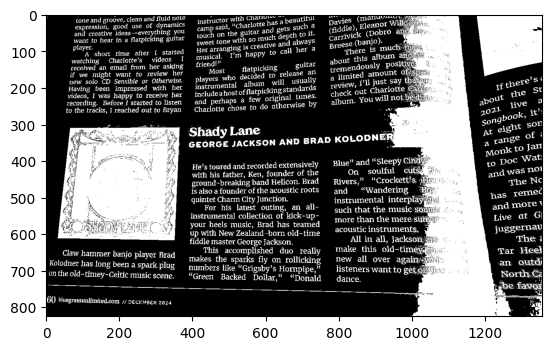

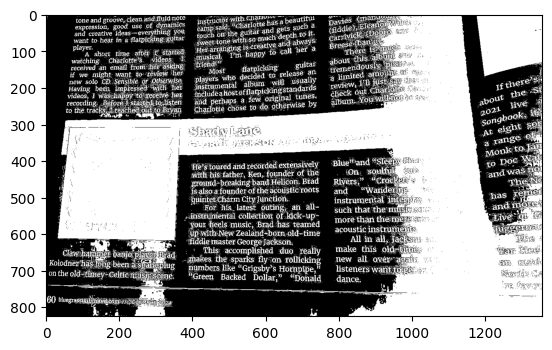

In [63]:
plt.imshow(np.where(image > np.mean(image), 0, 1), 'gray')
plt.show()
plt.imshow(np.where(image > np.median(image), 0, 1), 'gray')
plt.show()

### Method 1: KMeans

C:\Users\ycn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


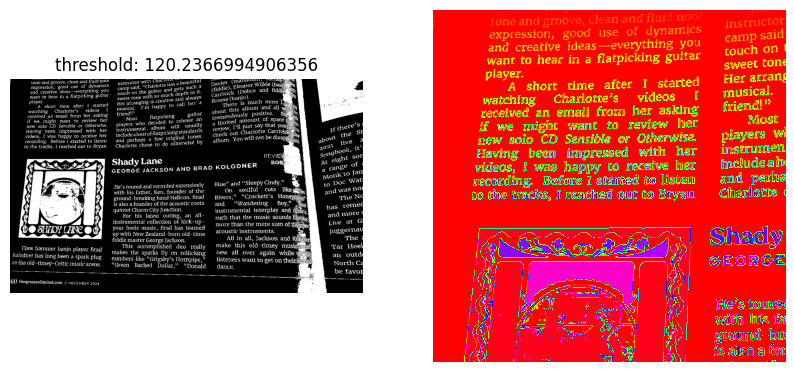

In [7]:
kmeans = KMeans(2, random_state=42)
labels = kmeans.fit_predict(image.reshape(-1,1)).reshape(shape)
_, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.axis('off')
ax1.set_title(f'threshold: {np.mean(kmeans.cluster_centers_)}')
ax1.imshow(1-labels, 'gray')
ax2.axis('off')
ax2.imshow(ccl(1 - labels[:500,:500]), 'hsv')
plt.show()

### Method 2: Vanilla thresholding(Otsu's method)

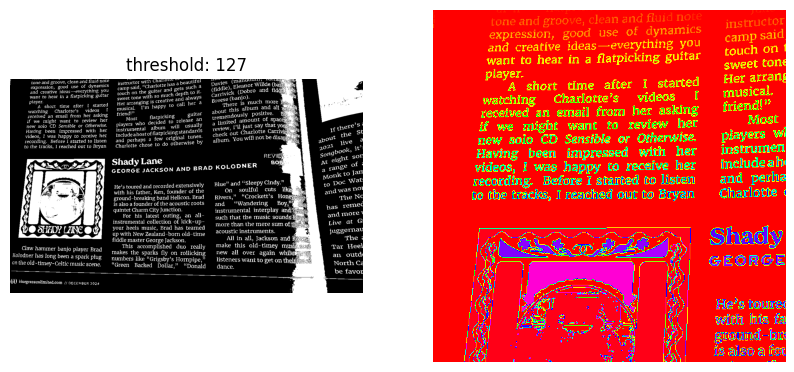

In [8]:
def otsu(image):
    uniques = np.unique(image.flatten()).astype(np.uint16)
    t, total_var = None, np.inf
    for i in range(len(uniques) - 1):
        sep = (uniques[i] + uniques[i+1])/2
        l = uniques[uniques <= sep]
        r = uniques[uniques > sep]
        new_total_var=len(l) * np.var(l) + len(r) * np.var(r)
        if new_total_var < total_var:
            total_var = new_total_var
            t = i
    return np.where(image < t, 0, 1), t

res, t = otsu(image)
_, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.axis('off')
ax1.set_title(f'threshold: {t}')
ax1.imshow(1- res, 'gray')
ax2.axis('off')
ax2.imshow(ccl(1 - res[:500,:500]), 'hsv')
plt.show()

### Method 3: Adaptive thresholding(Otsu's Method)

In [9]:
h, w = image.shape
# Select tile size manually; In this case, I choose 55x59 for tile size
print(*{f'h({h}): {[i for i in range(1,(h//2)+1) if not h%i]}, w({w}): {[i for i in range(1,(w//2)+1) if not w%i]}'})

h(825): [1, 3, 5, 11, 15, 25, 33, 55, 75, 165, 275], w(1357): [1, 23, 59]


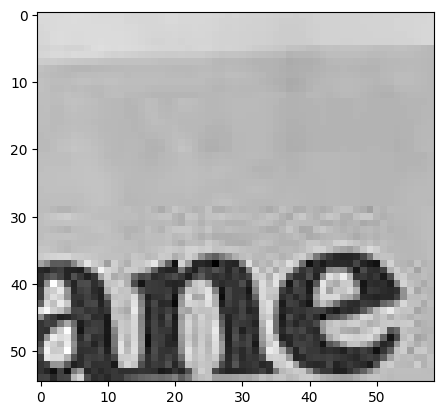

In [10]:
h_size = 55
w_size = 59
h_bins = h//h_size
w_bins = w//w_size
tiles = image.reshape(h_bins, h_size, w_bins, w_size)
tiles = tiles.swapaxes(1, 2)
plt.imshow(tiles[5,9], 'gray')

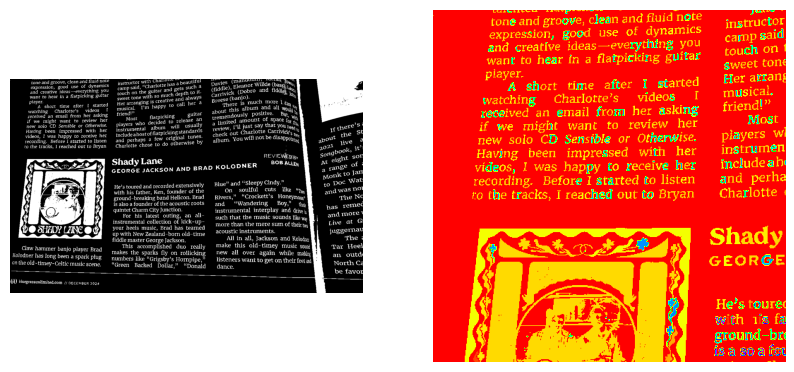

In [11]:
def adaptive_otsu(image, h_size, w_size):
    h_bins = h//h_size
    w_bins = w//w_size
    tiles = image.reshape(h_bins, h_size, w_bins, w_size)
    tiles = tiles.swapaxes(1, 2)
    new_tiles = np.zeros_like(tiles)
    for row_i in range(tiles.shape[0]):
        for col_i in range(tiles.shape[1]):
            new_tiles[row_i, col_i] = otsu(tiles[row_i, col_i])[0]
    return new_tiles.swapaxes(1,2).reshape(image.shape)

res = adaptive_otsu(image, 275, 59)

_, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.axis('off')
ax1.imshow(1-res, 'gray')
ax2.axis('off')
ax2.imshow(ccl(1 - res[:500,:500]), 'hsv')
plt.show()

### Adjusting bin sizes

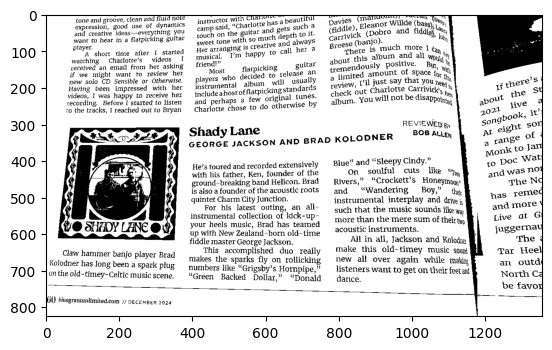

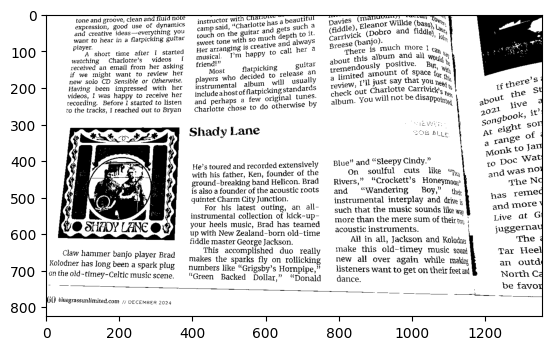

In [12]:
plt.imshow(adaptive_otsu(image, 165, 59), 'gray')
plt.show()
plt.imshow(adaptive_otsu(image, 55, 59), 'gray')
plt.show()

h(844): [1, 2, 4, 211, 422], w(1224): [1, 2, 3, 4, 6, 8, 9, 12, 17, 18, 24, 34, 36, 51, 68, 72, 102, 136, 153, 204, 306, 408, 612]


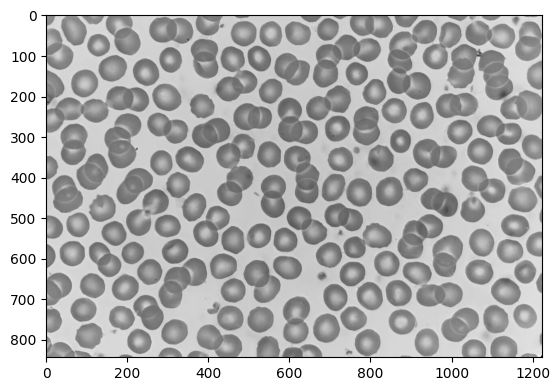

In [53]:
blood_cells = plt.imread('blood_cells.jpg')[:,:,0]
h, w = blood_cells.shape
# Select tile size manually; In this case, I choose 211x204 for tile size
print(*{f'h({h}): {[i for i in range(1,(h//2)+1) if not h%i]}, w({w}): {[i for i in range(1,(w//2)+1) if not w%i]}'})
plt.imshow(blood_cells, 'gray')
plt.show()

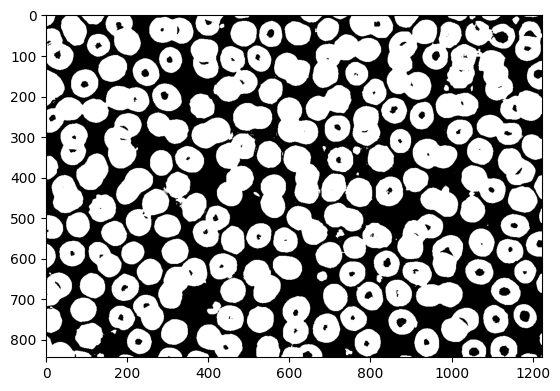

In [41]:
thrsh_res = adaptive_otsu(1 - blood_cells, 211,204)
plt.imshow(thrsh_res, 'gray')
plt.show()

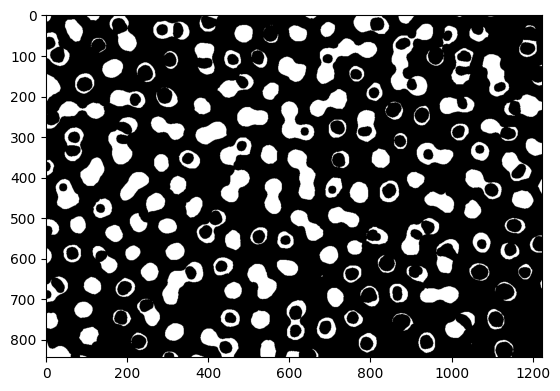

In [49]:
ero_res = erosion(thrsh_res, 'circle', 21)
plt.imshow(ero_res, 'gray')
plt.show()

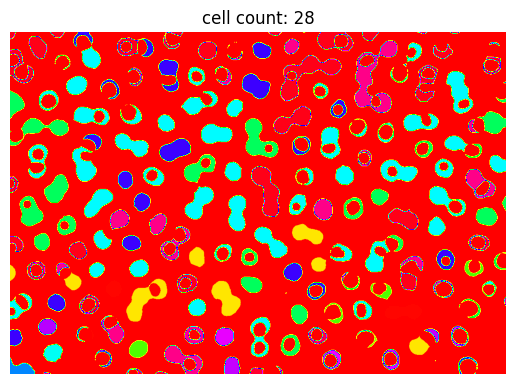

In [51]:
ccl_res = ccl(ero_res)
plt.axis('off')
plt.title(f'cell count: {len(np.unique(ccl_res))}')
plt.imshow(ccl_res, 'hsv')
plt.show()

### Problem: Why is connected component labeling algorithm acting strange when it is given an adaptive thresholded image?